In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.gaussian_process as skgp

In [18]:
D = 3
N = 1e8
#true_nlist = [1.5] + list(range(2, 21))
true_nlist = [1.5, 3, 6, 12, 24]
#true_nlist = list(range(2, 21))
m = 2/3
#nlist = [round((tnn-2*m)/(1-m),4) for tnn in true_nlist]
nlist = [round(tnn/(1-m)-1, 4) for tnn in true_nlist]
s = 1.0
sc = 1.0
c = s / sc
L = 1.0
num_empty = 200
res_dir = 'nsc-setisaturday-numempty200'
randix = 0

smoothing_method = 'convolve'

nsc-setisaturday-numempty200/D=3_n=3.5_N=1.00e+08_s=1.0_L=1.0_c=1.00000e+00_r=0
nsc-setisaturday-numempty200/D=3_n=8.0_N=1.00e+08_s=1.0_L=1.0_c=1.00000e+00_r=0
nsc-setisaturday-numempty200/D=3_n=17.0_N=1.00e+08_s=1.0_L=1.0_c=1.00000e+00_r=0
nsc-setisaturday-numempty200/D=3_n=35.0_N=1.00e+08_s=1.0_L=1.0_c=1.00000e+00_r=0
nsc-setisaturday-numempty200/D=3_n=71.0_N=1.00e+08_s=1.0_L=1.0_c=1.00000e+00_r=0


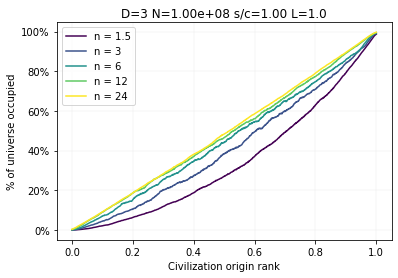

In [20]:
plot_data = []
cmap = plt.get_cmap('viridis')
mycols = cmap(np.linspace(0, 1, len(nlist)))
fig = plt.figure()
for nix, n in enumerate(nlist):
    fout = (
        f"{res_dir}/D={D}_n={float(n)}_N={N:.2e}_"
        f"s={s:.1f}_L={L:.1f}_c={c:.5e}_r={randix}"
    )
    print(fout)
    res = pd.read_csv(fout+'.csv')
    if smoothing_method == 'convolve':
        window_size = round(0.03*res.PctEmpty.shape[0])
        weights = [1/window_size]*window_size
        fitted_1minusPctEmpty = np.convolve(
            np.r_[1-res.PctEmpty, (1-res.PctEmpty).values[-5:-1].mean()*np.ones(1*window_size)]
            ,np.array(weights)[::-1],'same'
        )[0:-1*window_size]
        xvals = np.linspace(0,1, res.PctEmpty.shape[0])
    elif smoothing_method == 'gp':
        mykern = skgp.kernels.RBF(length_scale=0.1, length_scale_bounds=(0.1, 0.11))
        gpr = skgp.GaussianProcessRegressor(kernel=mykern, random_state=0)
        gpr.fit(np.linspace(0,1, res.PctEmpty.shape[0]).reshape(-1, 1), 1-res.PctEmpty)
        fitted_1minusPctEmpty = gpr.predict(np.linspace(0,1, 1000).reshape(-1, 1))
        xvals = np.linspace(0,1, 1000)
    elif smoothing_method == 'rolling':
        window_size = max(100,int(res.shape[0]/30))
        fitted_1minusPctEmpty = 1-res.PctEmpty.rolling(
            window=100, win_type='gaussian', center=True
        ).mean(std=1000)
        xvals = np.linspace(0,1, res.PctEmpty.shape[0])
    else:
        fitted_1minusPctEmpty = 1-res.PctEmpty
        xvals = np.linspace(0,1, res.PctEmpty.shape[0])
    plt.plot(
        xvals, 
        fitted_1minusPctEmpty,
        color=mycols[nix]
    )
leg = [f"n = {nn}" for nn in true_nlist]
plt.legend(leg);
plt.grid(linewidth=0.1);
"""
for nix, n in enumerate(nlist):
    fout = (
        f"{res_dir}/D={D}_n={float(n)}_N={N:.2e}_"
        f"s={s:.1f}_L={L:.1f}_c={c:.5e}_r={randix}"
    )
    res = pd.read_csv(fout+'.csv')
    plt.plot(
        np.linspace(0,1, res.PctEmpty.shape[0]), 
        1-res.PctEmpty,
        color=mycols[nix], alpha=0.1
    )
"""
plt.xlabel('Civilization origin rank');
plt.ylabel('% of universe occupied');
plt.gca().set_yticks(np.linspace(0, 1, 6));
plt.gca().set_yticklabels([f'{100*fo:.0f}%' for fo in list(np.linspace(0, 1, 6))]);
plt.gca().set_title(f'D={D} N={N:.2e} s/c={s/c:.2f} L={L:.1f}');
fig.savefig('figures-friday/plotB.png', dpi=200);